# Random Forest Pipeline

 

## Random Forest Modeling and Analysis

### This file is a pipeline of Random Forest modeling.
The Pipeline will be as follows:

1. Read the data in with custom function built at the end of the `Baseball_EDA` notebook.
2. Build a Pipeline object with two components: a random undersampler and the classification model. Random Undersampler was chosen due to imbalance of the target classes. 
3. Fit the pipeline to training data and verify results using 5-fold cross validation. This process will use custom function in the `Evaluation.py` module.  
4. Apply the pipeline to testing data to get test results that will be compared with other models. 

In [10]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
from data_import import prepare_data
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
#Read in the data as pandas dataframe
file = '../Statcast_data.csv'

#define bsb as the full dataframe
bsb = prepare_data('../Statcast_data.csv')

#filter out the predictors and the target
X = bsb.drop(columns = ['player_name', 'description'])
y = bsb['description']

#quick look to see above worked. 
X.head()



,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,vx0,vz0,vy0,sz_top,sz_bot,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,2314.0,3.2655,54.4995,5.2575,-9.8035,0.1339,-138.1130,3.2971,1.5059,1,0,1,0,0,0,0,0,0,0
1,2324.0,3.1728,54.3094,5.3966,-9.0084,-2.4218,-140.5865,3.3136,1.5730,1,0,0,1,0,0,0,0,0,0
2,2521.0,3.3517,55.0820,5.1205,-3.7285,1.2140,-117.3223,3.9119,1.7080,1,0,0,0,0,0,0,0,1,0
3,2329.0,3.1334,54.0207,5.2136,-12.0533,-5.1407,-139.3669,3.5553,1.5639,1,0,0,1,0,0,0,0,0,0
4,2437.0,3.3033,54.3597,5.0589,-14.0287,-3.3434,-139.8559,3.3450,1.6241,1,0,0,1,0,0,0,0,0,0


# Random Forest

In [12]:
#split the data into training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 777)

#build the pipeline object
#use a vanilla Random Forest Classifier
forest = RandomForestClassifier()
sampler = RandomUnderSampler(ratio = 1, random_state=777)

forest_pipe = make_pipeline(sampler, forest)

forest_pipe_results = cross_validate(forest_pipe, X_train, y_train, 
                            scoring = ['accuracy', 'f1', 'roc_auc'], 
                            cv =5, return_estimator=True, return_train_score = True)

for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
    print(f"Mean {result} Value: {np.mean(forest_pipe_results[result])}")
    print(f"{result} scores: {forest_pipe_results[result]}")
    print() 

Mean train_accuracy Value: 0.9209111499009527
train_accuracy scores: [0.92107413 0.91954568 0.91999368 0.92096872 0.92297354]

Mean test_accuracy Value: 0.7778177605845709
test_accuracy scores: [0.7721092  0.77474439 0.77585116 0.78091072 0.78547333]

Mean train_f1 Value: 0.8889017407470478
train_f1 scores: [0.88916438 0.88708902 0.8877717  0.88900814 0.89147546]

Mean test_f1 Value: 0.681007366141705
test_f1 scores: [0.67385729 0.67869493 0.67812003 0.68500417 0.6893604 ]

Mean train_roc_auc Value: 0.9833950913237338
train_roc_auc scores: [0.98361032 0.9829219  0.98340835 0.98327353 0.98376136]

Mean test_roc_auc Value: 0.8487655203831241
test_roc_auc scores: [0.84160552 0.84858541 0.84480038 0.85179018 0.85704612]



In [13]:
predictions = forest_pipe_results['estimator'][0].predict(X_test)

eval_test_set(predictions, y_test)



Accuracy Score: 0.7683647977737722

AUC Score: 0.7595651492859303

F1 Score: 0.6714509979816101

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.78      0.82     21437
           1       0.62      0.73      0.67     10186

    accuracy                           0.77     31623
   macro avg       0.74      0.76      0.75     31623
weighted avg       0.78      0.77      0.77     31623


 Confustion Matrix: 
 [[16813  4624]
 [ 2701  7485]]


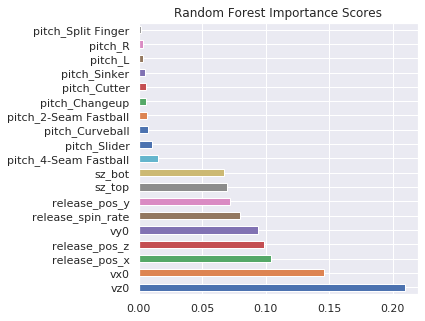

In [14]:
forest_clf = forest_pipe_results['estimator'][0].steps[1][1]

#show feature importances
fig = plt.figure(figsize = (5,5))
importances = pd.Series(forest_clf.feature_importances_, index=X_train.columns) \
.sort_values(ascending = False).plot(kind = 'barh', title='Random Forest Importance Scores')
fig.savefig('../images/Base_random_forest_feat_imp.png', bbox_inches = 'tight')

## Analysis

The Random Forest is able to get more depth in its feature importances, in that it is able to use more features for predictive value than the basic decision tree. Here, it says that the velocity in the three dimensions are the three most important, with the velocity in the z-dimension being the most important. Of course, we don't necessarily know how the values of these features impact the model's predictions and its overall performance. 

In [15]:
#save the model for future use. 
from sklearn.externals import joblib

filename = '../Models/Basic_random_forest.sav'
joblib.dump(forest_pipe_results['estimator'][0], filename)

['../Models/Basic_random_forest.sav']

## Tuning



In [17]:
from skopt import BayesSearchCV

ITERATIONS = 50
bayes_cv_tuner = BayesSearchCV(
    estimator = forest_pipe,
    search_spaces = {
        'forest__min_samples_split': (0.01, 1.0),
        'forest__max_depth': (1, 50),
        'forest__min_samples_leaf': (0.01, 0.5 ),
        'forest__max_features': (0.01, 1.0, ),
        'forest__n_estimators': (50, 750),
    },
    scoring = 'f1',
    cv = 3,
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 2019)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

TypeError: __init__() got an unexpected keyword argument 'fit_params'

In [27]:
results = bayes_cv_tuner.fit(X_train, y_train, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #2
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #3
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #4
Best ROC-AUC: 0.5
Best params: {'forest__max_depth': 31, 'forest__max_features': 0.9543275764819017, 'forest__min_samples_leaf': 0.4203923505859177, 'forest__min_samples_split': 0.2555369699930762, 'forest__n_estimators': 86}

Model #5
Best ROC-AUC: 0.5
Best params: {'forest__max_de

In [28]:
forest_best = results.best_estimator_

predictions = forest_best.predict(X_test)

eval_test_set(predictions, y_test)

Accuracy Score: 0.7333270088226923

AUC Score: 0.7552854637565968

F1 Score: 0.6637157554731428

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     21437
           1       0.56      0.82      0.66     10186

   micro avg       0.73      0.73      0.73     31623
   macro avg       0.72      0.76      0.72     31623
weighted avg       0.78      0.73      0.74     31623


 Confustion Matrix: 
 [[14868  6569]
 [ 1864  8322]]


In [29]:
from sklearn.externals import joblib

filename = 'Models/tuned_random_forest.sav'
joblib.dump(forest_best, filename)

['Models/tuned_random_forest.sav']